# CAN Workshop- LFADS demo in pytorch

## Import necessary modules

In [1]:
%matplotlib inline

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import os
import yaml

from lfads import LFADS_Net
from utils import read_data, load_parameters, save_parameters

# plt.style.use('dark_background')

In [2]:
# Select device to train LFADS on
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


## Load or Generate Data 

In [3]:
if False and os.path.exists('./synth_data/chaotic_rnn_300'):
    data_dict = read_data('./synth_data/chaotic_rnn_300')
else:
    if not os.path.isdir('./synth_data'):
        os.mkdir('./synth_data/')
    
    from synth_data_chaotic_rnn import generate_data
    data_dict = generate_data(T= 0.3, dt_rnn= 0.01, dt_cal= 0.01,
                              Ninits= 400, Ntrial= 10, Ncells= 50, trainp= 0.8,
                              tau=0.025, gamma=1.5, maxRate=30, B=20,
                              seed=300, save=True)

train_data = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data = torch.Tensor(data_dict['valid_spikes']).to(device)

print(train_data.shape)

train_truth = torch.Tensor(data_dict['train_rates']).to(device)
valid_truth = torch.tensor(data_dict['valid_rates']).to(device)

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

num_trials, num_steps, num_cells = train_data.shape
print(train_data.shape)

Saving variable with name:  train_spikes
Saving variable with name:  valid_spikes
Saving variable with name:  train_rates
Saving variable with name:  valid_rates
Saving variable with name:  perturb_times
torch.Size([3200, 30, 50])
torch.Size([3200, 30, 50])


## View Example Trial

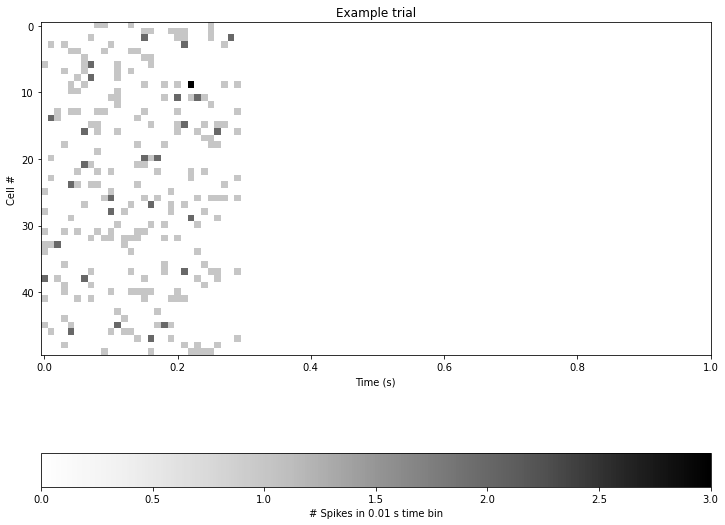

In [4]:
plt.figure(figsize = (12,12))
plt.imshow(data_dict['train_spikes'][0].T, cmap=plt.cm.Greys)
plt.xticks(np.linspace(0, 100, 6), ['%.1f'%i for i in np.linspace(0, 1, 6)])
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='# Spikes in 0.01 s time bin')
plt.title('Example trial');

## View example Ground Truth Firing Rates

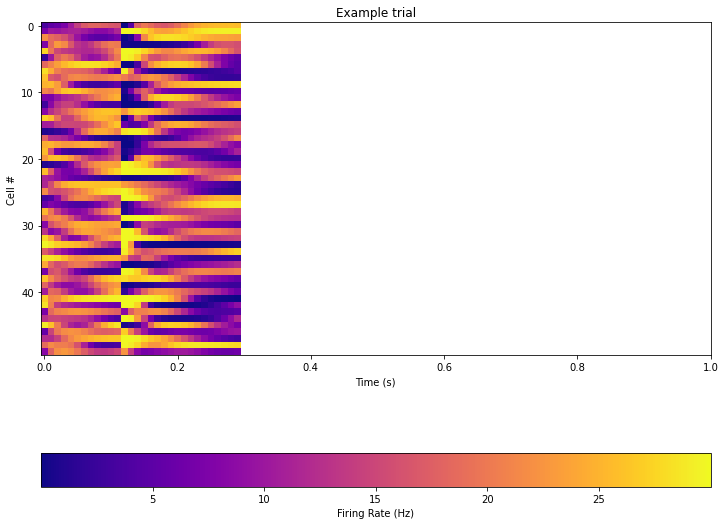

In [5]:
plt.figure(figsize = (12,12))
plt.imshow(data_dict['train_rates'][0].T, cmap=plt.cm.plasma)
plt.xticks(np.linspace(0, 100, 6), ['%.1f'%i for i in np.linspace(0, 1, 6)])
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)')
plt.title('Example trial');

## LFADS Schema
<img src='lfads_schema.png' width=800 align=left>

## Load model hyperparameters 

In [6]:
hyperparams = load_parameters('./parameters_demo.yaml')
save_parameters(hyperparams)
hyperparams

C:\Users\jhazelde\Desktop\lfads_demo\utils.py:91: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(open(path))


{'dataset_name': 'chaotic_rnn',
 'run_name': 'demo',
 'g_dim': 200,
 'u_dim': 1,
 'factors_dim': 20,
 'g0_encoder_dim': 200,
 'c_encoder_dim': 128,
 'controller_dim': 128,
 'g0_prior_kappa': 0.1,
 'u_prior_kappa': 0.1,
 'keep_prob': 0.95,
 'clip_val': 5.0,
 'max_norm': 200,
 'learning_rate': 0.01,
 'learning_rate_min': 1e-05,
 'learning_rate_decay': 0.95,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'scheduler_cooldown': 6,
 'kl_weight_schedule_start': 0,
 'kl_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'l2_weight_schedule_dur': 2000,
 'epsilon': 0.1,
 'betas': (0.9, 0.99),
 'l2_gen_scale': 2000,
 'l2_con_scale': 0}

## Instantiate LFADS model

In [7]:
model = LFADS_Net(inputs_dim = num_cells, T = num_steps, dt = 0.01, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 7369


#### Pick up where you left off (if you have a recent save) 

In [13]:
model.load_checkpoint('recent')

## Fit model

Rule of thumb: You can usually see good fit after 200 epochs (~30 mins runtime on Thinkpad GPU, ~2.5 hours on CPU), but to see good inference of perturbation timings need to run for about 800 epochs (~2 hours on Thinkpad GPU).

Beginning training...
Epoch:    2, Step:    47, training loss: 188.348, validation loss: 396.890
Epoch:    3, Step:    63, training loss: 173.875, validation loss: 380.806
Epoch:    4, Step:    79, training loss: 168.843, validation loss: 362.445
Epoch:    5, Step:    95, training loss: 166.011, validation loss: 353.839
Epoch:    6, Step:   111, training loss: 165.931, validation loss: 349.652
Epoch:    7, Step:   127, training loss: 161.606, validation loss: 343.020
Epoch:    8, Step:   143, training loss: 157.464, validation loss: 338.858
Epoch:    9, Step:   159, training loss: 154.197, validation loss: 335.570
Epoch:   10, Step:   175, training loss: 152.082, validation loss: 331.357
Epoch:   11, Step:   191, training loss: 150.027, validation loss: 325.861
Epoch:   12, Step:   207, training loss: 148.676, validation loss: 319.483
Epoch:   13, Step:   223, training loss: 148.300, validation loss: 312.243
Epoch:   14, Step:   239, training loss: 148.552, validation loss: 310.953
Epo

ValueError: Cannot take a larger sample than population when 'replace=False'

<Figure size 3600x2400 with 0 Axes>

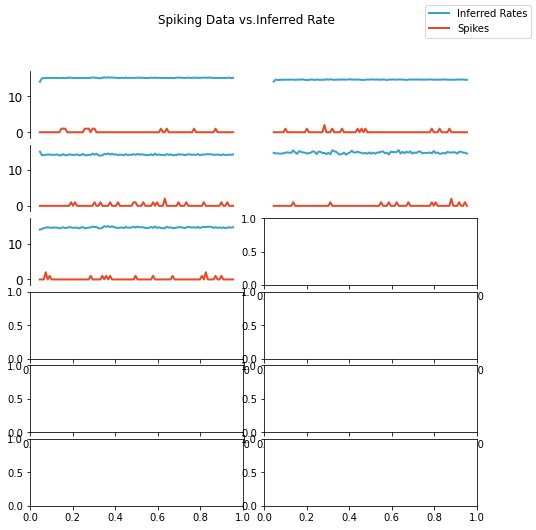

<Figure size 3600x2400 with 0 Axes>

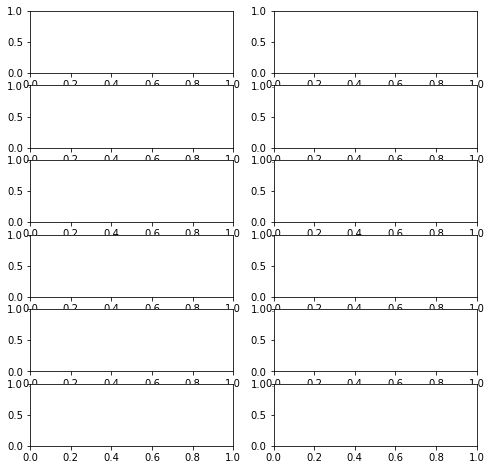

In [30]:
model.fit(train_ds, valid_ds, max_epochs=200, batch_size=200, use_tensorboard=True,
          train_truth=train_truth, valid_truth=valid_truth) # Without BNN Epoch 1 loss = 2668, 3692, epoch 200 loss = 2115, 2105

## Load checkpoint with lowest validation error 

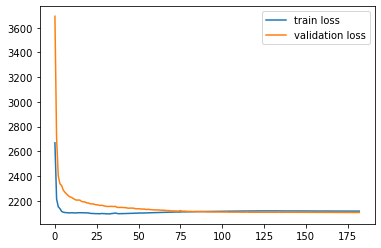

In [8]:
model.load_checkpoint('best')
plt.plot(model.train_loss_store, label='train loss')
plt.plot(model.valid_loss_store, label='validation loss')
plt.legend()

## Plot results summary 

torch.Size([100, 30, 1])


<Figure size 3600x2400 with 0 Axes>

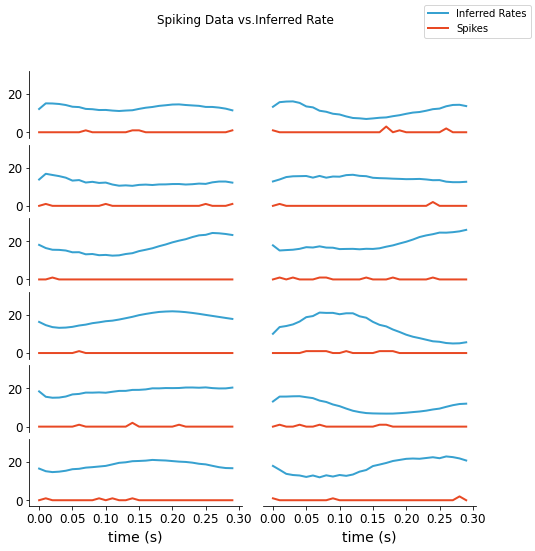

<Figure size 3600x2400 with 0 Axes>

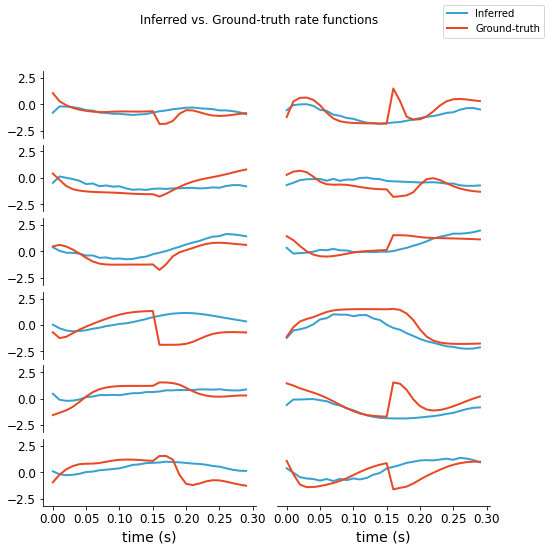

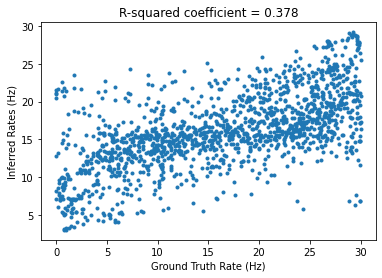

<Figure size 3600x2400 with 0 Axes>

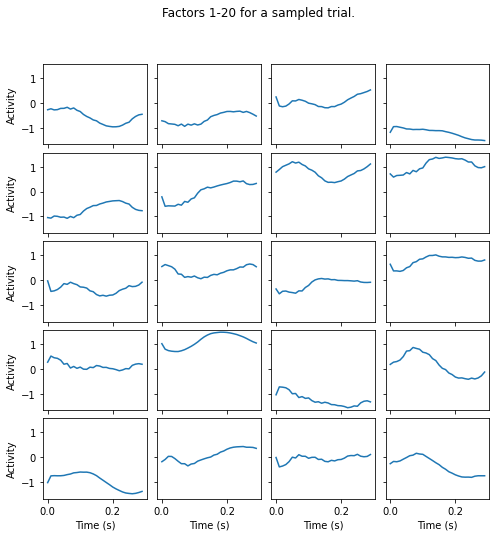

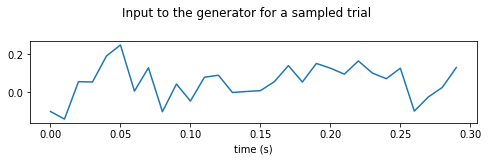

In [34]:
_, true, pred = model.plot_summary(data=valid_data, truth=valid_truth)

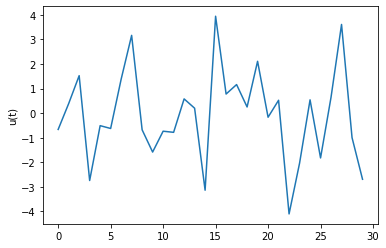

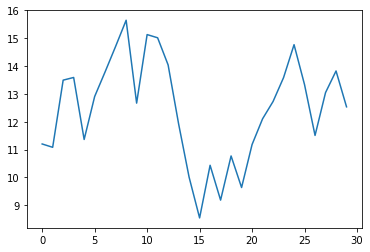

In [106]:
plt.figure()
plt.plot(model.inputs[0, :, 0])
plt.ylabel('u(t)')

u = 1.0
model.generate(torch.zeros(100, 30, 1).to(device), torch.randn((100, 30, 1)).to(device) * u)
rates = model.rates

plt.figure()
plt.plot(rates[0, :, 0])

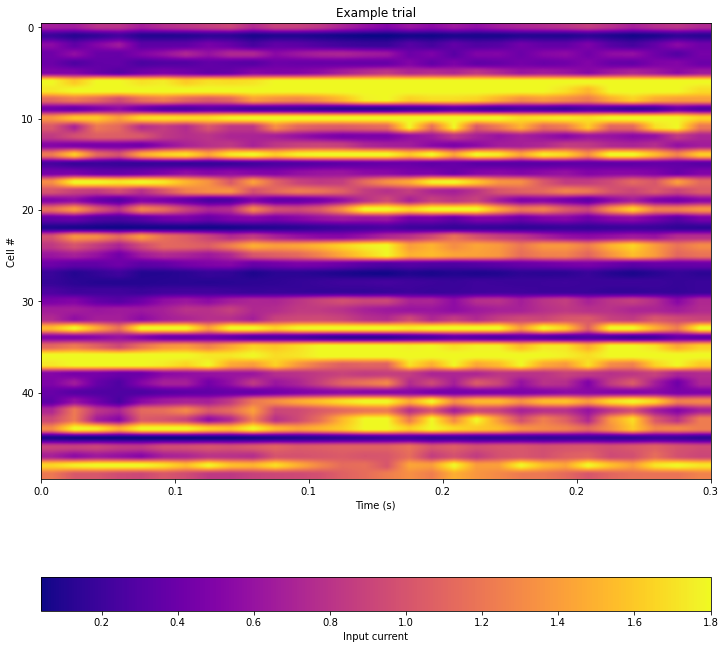

In [107]:
from bnn import BNN
from config import CFG
import torchvision

plt.figure(figsize = (12,12))
T = 0.3
CFG.dt = 0.1
CFG.sim_t = int((T * 1000) / CFG.dt)

r = model.rates[0:1, :, :]
z = torch.clamp(0.059 * r, 0.0, 1.8)
interp = torchvision.transforms.Resize((CFG.sim_t, z.shape[2]))
z = interp(z)
plt.imshow(z[0, :, :].numpy().T, cmap='plasma', aspect='auto')
plt.xticks(np.linspace(0, CFG.sim_t, 6), ['%.1f'%i for i in np.linspace(0, T, 6)])
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Input current')
plt.title('Example trial');

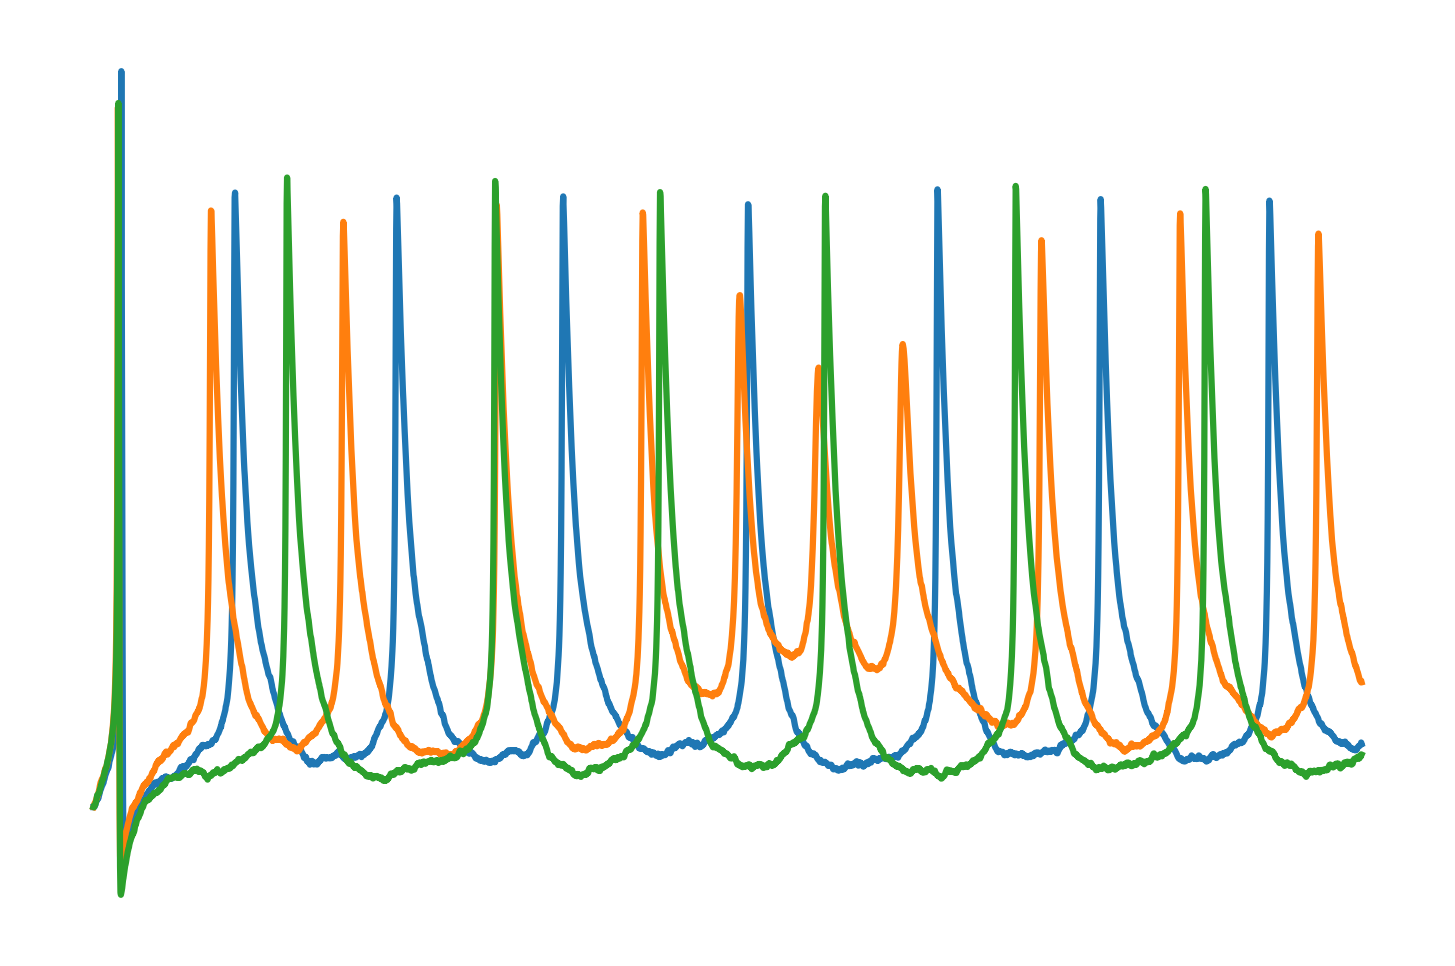

tensor(0.0406, device='cuda:0')


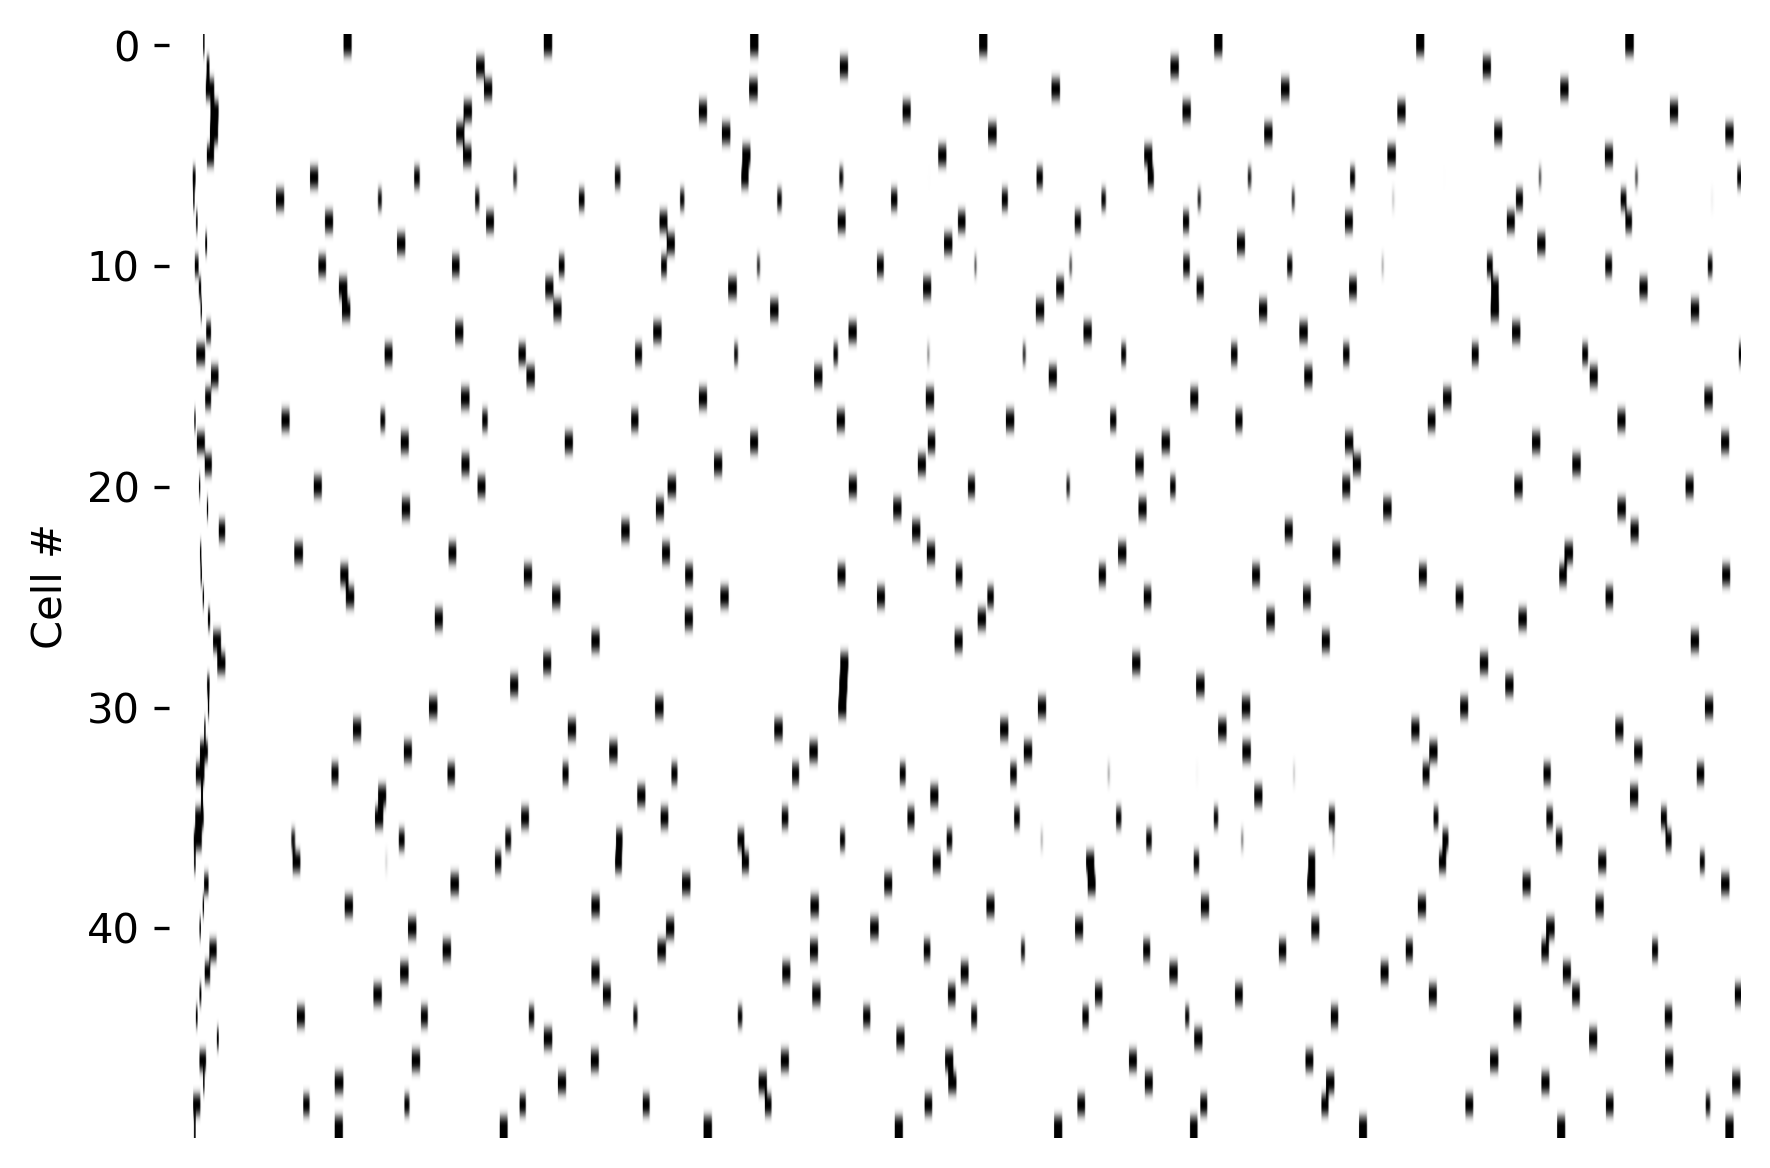

In [108]:
from bnn import HH_Gap
CFG.plot = False
z = z[0:1, :, :].cuda()
bnn = HH_Gap(z.shape[2])
out = bnn(z)

plt.figure(dpi=300)
# plt.subplot(2,1,1)
plt.plot(bnn.V[0, :, ::20].detach().cpu().numpy())
plt.box(False)
plt.xticks([])
plt.yticks([])
# plt.subplot(2,1,2)
# plt.plot(out[0, :, ::10].detach().cpu().numpy())
plt.savefig(f'traces_{u}.png')
plt.show()

print(torch.mean(out))

window_size = CFG.sim_t // r.shape[1]
comp_out = torch.zeros((z.shape[0], r.shape[1], z.shape[2]))
for i in range(comp_out.shape[1]):
    comp_out[:, i, :] = torch.sum(out[:, i*window_size:i*(window_size+1), :], dim=1)
    
plt.figure(dpi=300)
# plt.subplot(3,1,1)
plt.imshow(out[0, :, :].detach().cpu().numpy().T, aspect='auto', cmap='Greys')
plt.box(False)
plt.xticks([])
#plt.xticks(np.linspace(0, CFG.sim_t, 6), ['%.1f'%i for i in np.linspace(0, 1, 6)])
#plt.title('a(t)')
plt.ylabel('Cell #')

# plt.subplot(3,1,2)
# plt.imshow(z[0, :, :].detach().cpu().numpy().T, aspect='auto', cmap='hot')
# plt.xticks(np.linspace(0, CFG.sim_t, 6), ['%.1f'%i for i in np.linspace(0, 1, 6)])
# plt.colorbar()
# plt.ylabel('Cell #')
# plt.title('T(r(t))')

# plt.subplot(3,1,3)
# plt.imshow(comp_out[0, :, :].detach().cpu().numpy().T, aspect='auto', cmap='hot')
# plt.xticks(np.linspace(0, comp_out.shape[1], 6), ['%.1f'%i for i in np.linspace(0, 1, 6)])
# plt.colorbar()
# plt.xlabel('Time (s)')
# plt.title('Output')
# plt.ylabel('Cell #')

plt.tight_layout()
plt.savefig(f'mod1_result_{u}.png')
plt.show()

In [8]:
from scipy import stats

def compare_rates(r, out, k, plot=False):
    true_rates = torch.mean(r[0, :, :], 0).cuda().float()
    true_rates = (true_rates - torch.mean(true_rates)) / torch.std(true_rates)
    pred_rates = torch.mean(out[0, :, :], 0).float()
    if torch.std(pred_rates) > 0.00001:
        pred_rates = (pred_rates - torch.mean(pred_rates)) / torch.std(pred_rates)
    
    loss_fun = torch.nn.MSELoss()
    loss = loss_fun(pred_rates, true_rates)
    
    if plot:
        plt.figure(dpi=150)
        plt.plot(true_rates.cpu().detach().numpy(), zorder=5, color='black', linewidth=1)
        plt.plot(pred_rates.cpu().detach().numpy(), zorder=5, color='red', linewidth=1)
       # plt.title(f'k={k:.5f}, loss={loss.cpu().item():.5f}')
        
    return loss

In [ ]:
from bnn import HH_Gap
CFG.plot = False
z = z[0:1, :, :].cuda()
bnn = HH_Gap(z.shape[2])

k = torch.ones(()).float() * 0.5
k.requires_grad = True

ks = np.zeros(100)
losses = np.zeros(len(ks))
optim = torch.optim.Adam([k], lr=0.01)
grads = np.zeros(len(ks))

for idx in range(len(ks)):
#for idx, k in enumerate(ks):
    optim.zero_grad()
    T = 0.3
    CFG.dt = 0.1
    CFG.sim_t = int((T * 1000) / CFG.dt)
    r = torch.from_numpy(data_dict['train_rates'][0]).unsqueeze(0).cuda()
    interp = torchvision.transforms.Resize((CFG.sim_t, z.shape[2]))
    z = interp(z)
    z = torch.clamp(k * r, 0.0, 1.8)

    print(z.shape)
    loss_windows = []
    for sub in range(0, z.shape[1], z.shape[1]):
        optim.zero_grad()
        z_sub = z[:, sub:sub+z.shape[1], :]
        r_sub = r[:, sub:sub+z.shape[1], :]
        print(z_sub.shape)
        out = bnn(z_sub)

        loss = compare_rates(r_sub, out, k, True)
        plt.show()
        loss.backward()
        loss_windows.append(loss.item())
        print(loss.item(), k.grad)
        
    exit()
    losses[idx] = loss.cpu().item()
    ks[idx] = k.cpu().item()
    
    loss.backward()
    grad = k.grad
    grads[idx] = grad.cpu().item()
    print(idx, losses[idx], k.item(), grad.item())
    optim.step()
    
plt.plot(ks, losses)
plt.savefig(f'loss_gradient_find_2.pdf')
plt.show()

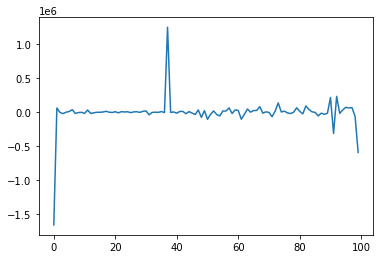

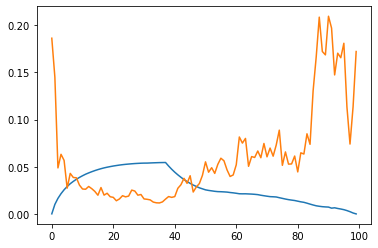

In [81]:
plt.plot(grads)
plt.figure()
plt.plot(ks)
plt.plot(losses / 10)

In [ ]:
from bnn import BNN
from torch.autograd import Variable
CFG.hidden_layers = []
bnn = BNN(z.shape[2], z.shape[2]).cuda().float()

T = 0.3
CFG.dt = 0.1
CFG.sim_t = int((T * 1000) / CFG.dt)

optim = torch.optim.Adam(bnn.parameters(), lr=0.01)
train_dl = torch.utils.data.DataLoader(data_dict['train_rates'], batch_size=50, shuffle=True)
loss_fun = torch.nn.MSELoss()
loss_record = []
bnn = torch.load('bnn_2_30.pt')
r = torch.from_numpy(data_dict['train_rates'][0]).unsqueeze(0)

#     z = torch.clamp(1.8 / 70.0 * r, 0.0, 1.8)
interp = torchvision.transforms.Resize((CFG.sim_t, r.shape[2]))
r = interp(r).float().cuda()
r = Variable(r)

bnn_out = bnn(r)
pred_rates = torch.mean(bnn_out, 1)
pred_rates = (pred_rates - torch.mean(pred_rates)) / torch.std(pred_rates)

true_rates = torch.mean(r, 1)
true_rates = (true_rates - torch.mean(true_rates)) / torch.std(true_rates)

plt.plot(true_rates[0, :].cpu().detach().numpy(), zorder=5, color='black', linewidth=3)
plt.plot(pred_rates[0, :].cpu().detach().numpy(), zorder=5, color='red', linewidth=3)

plt.figure()
plt.imshow(bnn_out.cpu().detach().numpy(), aspect='auto')

exit()
for epoch in range(100):
    for i, x in enumerate(train_dl, 0):
        print(i)
        if i % 10 == 0:
            plt.plot(loss_record)
            plt.title(f'{i}')
            plt.show()
            torch.save(bnn, f'bnn_{epoch}_{i}.pt')
        r = torch.from_numpy(data_dict['train_rates'][0]).unsqueeze(0)

    #     z = torch.clamp(1.8 / 70.0 * r, 0.0, 1.8)
        interp = torchvision.transforms.Resize((CFG.sim_t, r.shape[2]))
        r = interp(r).float().cuda()
        r = Variable(r)

        optim.zero_grad()

        bnn_out = bnn(r)
        pred_rates = torch.mean(bnn_out, 1)
        pred_rates = (pred_rates - torch.mean(pred_rates)) / torch.std(pred_rates)

        true_rates = torch.mean(r, 1)
        true_rates = (true_rates - torch.mean(true_rates)) / torch.std(true_rates)

        loss = loss_fun(pred_rates, true_rates)
        loss.backward()
        optim.step()

        loss_record.append(loss.cpu().item())

    #     plt.imshow(bnn_out.T, aspect='auto')

    #     pred_rates = np.mean(bnn_out[:, :], 0)
    #     plt.figure()
    #     plt.plot(stats.zscore(true_rates), zorder=5, color='black', linewidth=3)
    #     plt.plot(stats.zscore(pred_rates), zorder=5, color='red', linewidth=3)

    #     plt.figure()
    #     plt.plot(bnn_out[:, :5])

In [120]:
print(data_dict['train_rates'][0].shape)
print(r.shape)
print(model.u.shape)

(30, 50)
torch.Size([1, 3000, 50])


AttributeError: 'BNN' object has no attribute 'u'